In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# torchvision.datasetsを利用する場合は，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# データの読み込み
import torchvision.transforms as transforms
import numpy as np

batch_size=20000

# 画像をCHWの並びで，[-1.0,1.0]になるように変換
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 

trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=10)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=10)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

In [3]:
#modelの生成
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
model = nn.Sequential(
    nn.Conv2d(1,20,3, padding=1),
    nn.ReLU(),
    # nn.Dropout2d(p=5),
    # nn.BatchNorm2d(20),
    nn.MaxPool2d(2,2),
    nn.Conv2d(20,20,3, padding=1),
    nn.ReLU(),
    # nn.Dropout2d(p=5),
    # nn.BatchNorm2d(20),
    Flatten(),
    nn.Linear(3920, 10),
)

print(model)
num=0
for param in model.parameters():
    num += param.numel()
print("total num. of params:",num)
model = model.to(device)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Flatten()
  (6): Linear(in_features=3920, out_features=10, bias=True)
)
total num. of params: 43030


In [4]:
# 複数GPU使用宣言 
if torch.cuda.is_available() and torch.cuda.device_count()>1:
    model = torch.nn.DataParallel(model) 
    print(1)

1


In [5]:
model

DataParallel(
  (module): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten()
    (6): Linear(in_features=3920, out_features=10, bias=True)
  )
)

In [6]:
# callback のクラス ShowGraphを定義
class ShowGraph:
    def __init__(self,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0.9, 1.0])
        self.fig1.set_title('accuracy')
        self.fig1.set_ylabel('accuracy')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([0, max_epoch, 0, 0.3 ])
        self.fig2.set_title('loss')
        self.fig2.set_ylabel('loss')
        self.fig2.set_xlabel('epoch')
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.acc=[]
        self.acc_val=[]
        self.n_epoch=[]
        self.n_epoch_v=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, acc, vloss, vacc):
        self.n_epoch.append(epoch)
        self.n_epoch_v.append(epoch)
        self.acc.append(acc)
        self.acc_val.append(vacc)     
        self.losses.append(loss)
        self.losses_val.append(vloss)    
        self.test_acc=vacc
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
        self.fig1.plot(self.n_epoch_v,self.acc_val,"r")
        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
        self.fig2.plot(self.n_epoch_v,self.losses_val,"r")
        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
        
    def on_epoch_train(self, epoch, loss, acc): # validationを評価しないepochの表示用
        self.n_epoch.append(epoch)
        self.acc.append(acc)
        self.losses.append(loss)
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
#        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
#        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
              
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val acc値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("val_acc: ",self.test_acc) 
        print('Time: ',time.time()-self.start)
        
def train():
    loss=0
    total=0
    total0=0
    correct=0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        outputs = model(inputs.to(device))
        labels=labels.to(device)
        loss0= loss_fn(outputs, labels)
        loss+= loss0.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total0+=1
        correct += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss0.backward()
        optimizer.step()
    loss=loss/total0
    acc=correct/total 
    return loss, acc

def validate():
    with torch.no_grad():
         vloss=0
         total2=0
         total20=0
         correct2=0
         for (inputs, labels) in testloader:
             outputs = model(inputs.to(device))
             labels=labels.to(device)
             vloss += loss_fn(outputs, labels).item()
             _, predicted = torch.max(outputs.data, 1)
             total2 += labels.size(0)
             total20+=1
             correct2 += (predicted == labels).sum().item()
         vloss=vloss/total20
         vacc=correct2/total2
    return vloss, vacc   

# 2つの場合

val_acc:  0.9099
Time:  156.12377071380615


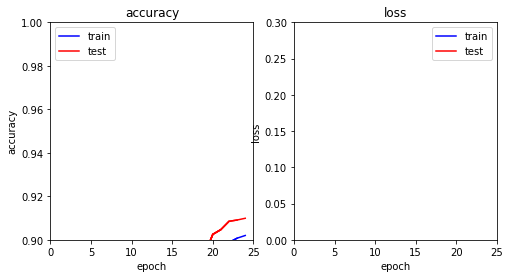

In [8]:
num_epoch=25
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.0001)
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) 
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

# 1つの場合

val_acc:  0.9183
Time:  167.53916931152344


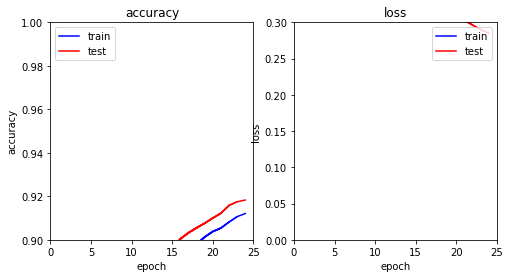

In [14]:
num_epoch=25
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.0001)
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) 
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

# 考察
MNISTではバッチサイズを20000程度にしないと処理速度に違いが見られなかった。原因としては並列化にすることによってI/O処理に時間がかかってしまうことが原因であると考えられる。